<a href="https://colab.research.google.com/github/valerielimyh/Intent_Recognition_using_BERT/blob/master/02_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install bert
! pip install bert-for-tf2
! pip install bert-tensorflow
! pip install tensorflow-gpu 

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights

In [8]:
import os
import math
import datetime
import pickle
from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, log_loss, f1_score, precision_recall_curve, make_scorer
from keras.models import model_from_json

#settings
pd.set_option('display.max_colwidth', -1)
np.set_printoptions(threshold=np.inf)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [0]:

import tensorflow_hub as hub


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# with open('/content/drive/My Drive/Metis/data/processed/df5.pkl', 'rb') as read_file:
#     df1 = pickle.load(read_file)

In [3]:
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 54.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 16.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 48.9MB/s]


In [0]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [5]:
train.info()
valid.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13084 entries, 0 to 13083
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13084 non-null  object
 1   intent  13084 non-null  object
dtypes: object(2)
memory usage: 204.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    700 non-null    object
 1   intent  700 non-null    object
dtypes: object(2)
memory usage: 11.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    700 non-null    object
 1   intent  700 non-null    object
dtypes: object(2)
memory usage: 11.1+ KB


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
#Let’s start by downloading one of the simpler pre-trained BERT models and unzip it:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-05-05 05:45:00--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   148MB/s    in 2.6s    

2020-05-05 05:45:03 (148 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [7]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
os.makedirs("model", exist_ok=True)

In [0]:
!mv uncased_L-12_H-768_A-12/ model

In [0]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [12]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [14]:
valid.head(2)

,text,intent
0,i d like to have this track onto my classical ...,AddToPlaylist
1,add the album to my flow español playlist,AddToPlaylist


In [6]:
train.intent.value_counts()
#target classes are rather balanced

PlayMusic               1914
GetWeather              1896
BookRestaurant          1881
RateBook                1876
SearchScreeningEvent    1852
SearchCreativeWork      1847
AddToPlaylist           1818
Name: intent, dtype: int64

# Let's preprocess our data so that it matches the data BERT was trained on. 

For this, we'll 

1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the readme)
6. Append "index" and "segment" tokens to each input (see the BERT paper)

In [0]:
# Let’s start by creating the BERT tokenizer
tokenizer = FullTokenizer(
  vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt")
)

In [20]:
# let's try it out
tokenizer.tokenize("This here's an example of using the BERT tokenizer")
# The tokens are in lowercase and the punctuation is available. 

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

In [21]:
# Next, we’ll convert the tokens to numbers. 
tokens = tokenizer.tokenize("This here's an example of using the BERT tokenizer")
tokenizer.convert_tokens_to_ids(tokens)
# The tokenizer can do this too

[2023, 2182, 1005, 1055, 2019, 2742, 1997, 2478, 1996, 14324, 19204, 17629]

In [0]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(
    self,
    train,
    valid,
    test,
    tokenizer: FullTokenizer,
    classes,
    max_seq_len=192
  ):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes

    ((self.train_x, self.train_y),(self.valid_x, self.valid_y), (self.test_x, self.test_y)) =\
     map(self._prepare, [train, valid, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.valid_x, self.test_x = map(
      self._pad,
      [self.train_x,self.valid_x, self.test_x]
    )

  def _prepare(self, df):
    x, y = [], []

    for _, row in tqdm(df.iterrows()):
      text, label =\
       row[IntentDetectionData.DATA_COLUMN], \
       row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    '''
    padding length is calculated by taking the minimum between the longest text and the max sequence length parameter. 
    surround the tokens for each text with two special tokens: start with [CLS] and end with [SEP]
    '''
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

# Creating a model

Now that we've prepared our data, let's build our model.

In [0]:
def create_model(max_seq_len, bert_ckpt_file):
  # loads the BERT model
  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")

  input_ids = keras.layers.Input(
    shape=(max_seq_len, ),
    dtype='int32',
    name="input_ids"
  )
  bert_output = bert(input_ids)

  print("bert shape:", bert_output.shape)

# create new layers that will be trained to adapt BERT to our classification task
#flatten the output and add Dropout with two Fully-Connected layers
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output) 
  cls_out = keras.layers.Dropout(0.5)(cls_out) # Dropout helps prevent overfitting
  logits = keras.layers.Dense(units=768, activation="relu")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(    units=len(classes),
    activation="softmax"
  )(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)

  return model

In [19]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, valid, test, tokenizer, classes, max_seq_len=128)

13084it [00:04, 3256.70it/s]
700it [00:00, 3170.81it/s]
700it [00:00, 3021.63it/s]


max seq_len 38


In [13]:
data.train_x.shape

(13084, 38)

In [14]:
# sample of train data
data.train_x[0]

array([  101,  4952,  2000,  2225,  3676,  2213,  2632, 25438, 27395,
        2006,  8224,  2189,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [33]:
data.train_y[0]

0

In [34]:
data.max_seq_len

38

In [20]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape: (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f0f8576d048> (prefix:bert_1). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_3 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 5383

In [0]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [24]:
log_dir = "log/intent_classification/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.2,
  batch_size=128,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Train on 10467 samples, validate on 2617 samples
Epoch 1/5
10467/10467 [==============================] - 4180s 399ms/sample - loss: 1.2348 - acc: 0.9566 - val_loss: 1.1931 - val_acc: 0.9736
Epoch 2/5
10467/10467 [==============================] - 4182s 400ms/sample - loss: 1.1946 - acc: 0.9775 - val_loss: 1.1856 - val_acc: 0.9805
Epoch 3/5
10467/10467 [==============================] - 4209s 402ms/sample - loss: 1.1863 - acc: 0.9835 - val_loss: 1.1804 - val_acc: 0.9855
Epoch 4/5
10467/10467 [==============================] - 4188s 400ms/sample - loss: 1.1813 - acc: 0.9868 - val_loss: 1.1780 - val_acc: 0.9874
Epoch 5/5
10467/10467 [==============================] - 4186s 400ms/sample - loss: 1.1806 - acc: 0.9874 - val_loss: 1.1781 - val_acc: 0.9874


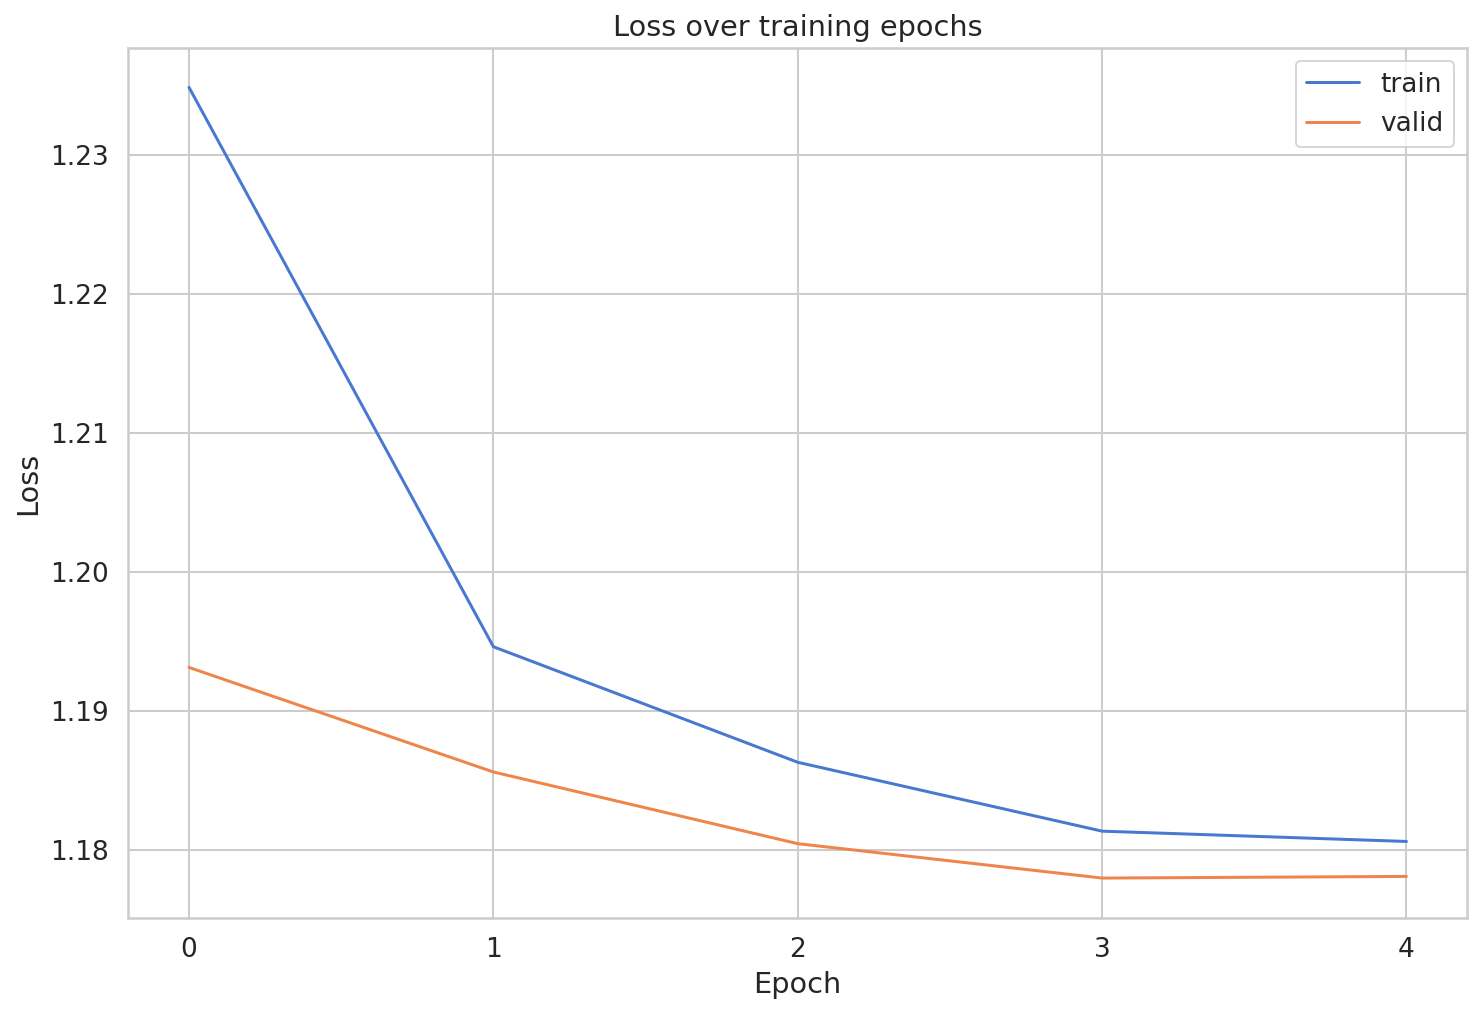

In [25]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.title('Loss over training epochs')
plt.show();

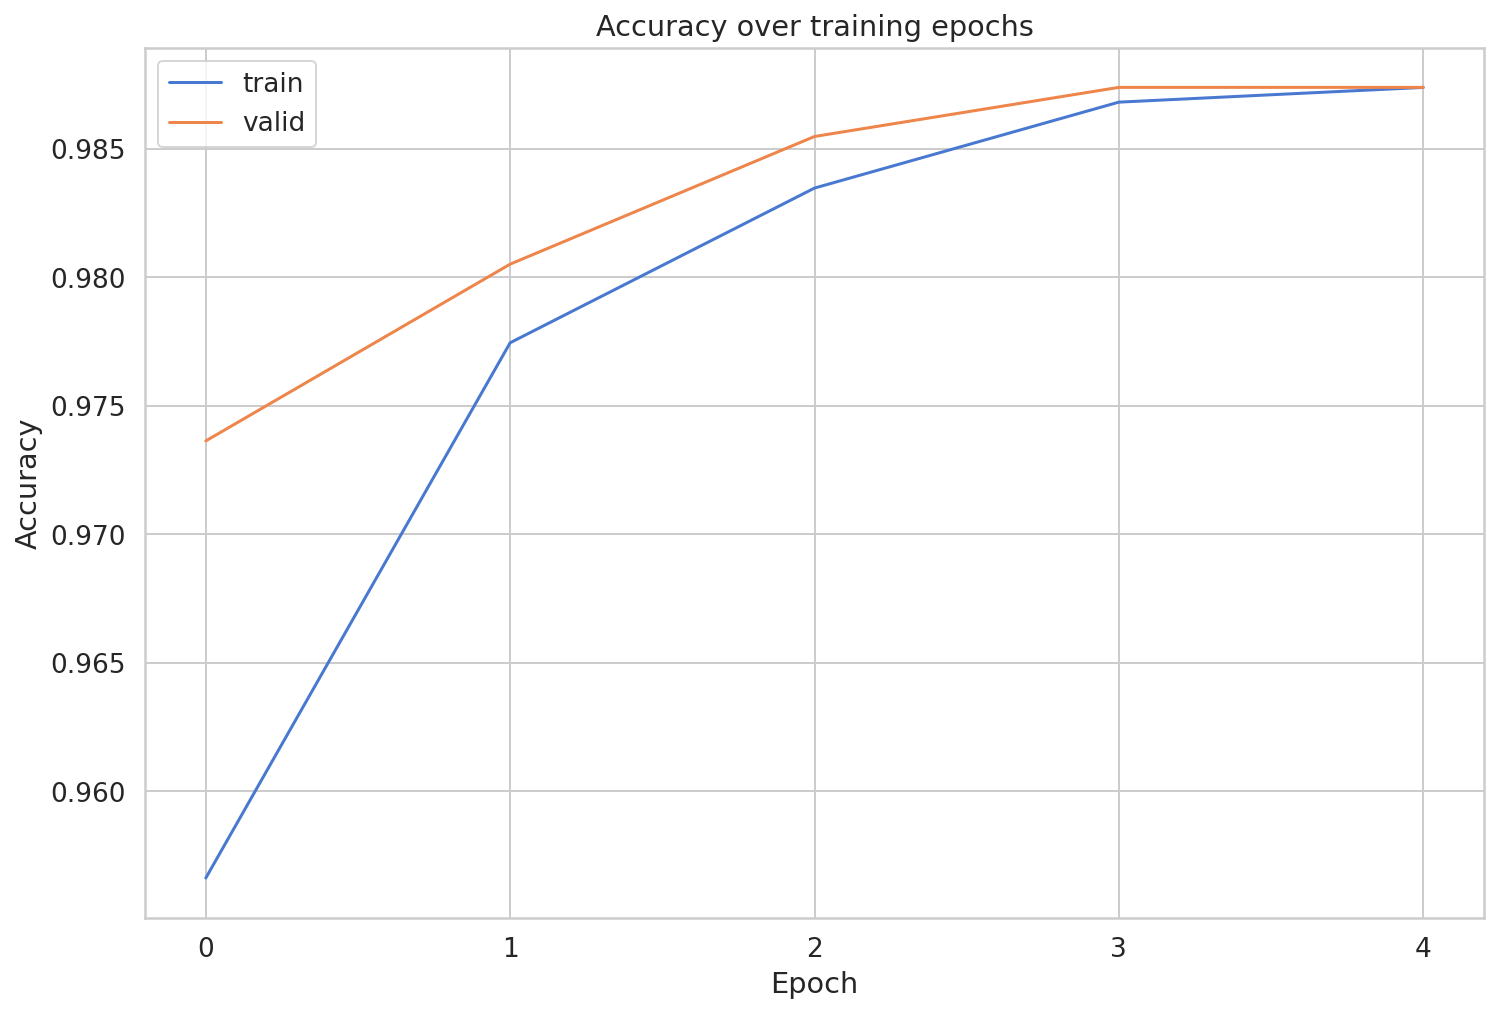

In [26]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.title('Accuracy over training epochs')
plt.show();

In [27]:
y_val_pred = model.predict(data.valid_x).argmax(axis=-1)
print(classification_report(data.valid_y, y_val_pred, target_names=classes))

# create new layers that will be trained to adapt BERT to our classification task

                      precision    recall  f1-score   support

           PlayMusic       1.00      0.97      0.98       100
       AddToPlaylist       0.99      1.00      1.00       100
            RateBook       1.00      0.99      0.99       100
SearchScreeningEvent       1.00      0.95      0.97       100
      BookRestaurant       1.00      1.00      1.00       100
          GetWeather       1.00      1.00      1.00       100
  SearchCreativeWork       0.93      1.00      0.96       100

            accuracy                           0.99       700
           macro avg       0.99      0.99      0.99       700
        weighted avg       0.99      0.99      0.99       700



In [0]:
# will continue to fine tune the model and evaluate on test set

References:

https://www.curiousily.com/posts/intent-recognition-with-bert-using-keras-and-tensorflow-2/